In [1]:
import sys
import os
import cv2
import json
from operator import *
from functools import *
from itertools import *
import numpy as np
import math
from darwinutils.fn import *
from darwinutils.helper import get_dict_filter_function_per_keys
from labelme.utils import *
import imutils

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
f_expand = f_compose_r(
    os.path.expanduser,
    os.path.expandvars,
)

In [3]:
work_dir = f_expand("~/workspace/opencv-practice/face-detection")
if work_dir not in sys.path:
    sys.path.append(work_dir)

In [5]:
def load_labeled_img(img_path: str):
    from labelme.utils import img_b64_to_arr

    with open(img_path, "r") as fd:
        img_data = json.load(fd)
    keys = set(img_data.keys()) - {"imageData", "shapes"}
    return f_compose_r(
        # f_dict_filter_func_per_AOI_keys,
        f_group(
            f_compose_r(
                itemgetter("imageData"),
                img_b64_to_arr,
            ),
            itemgetter(
                "imageHeight",
                "imageWidth",
            ),
            itemgetter("shapes"),
            # template for sub-shapes by excluding "imageData" and "shapes"
            get_dict_filter_function_per_keys(keys),
        ),
        tuple,
    )(img_data)


def _warp_transform(f_wrap, f_transform, m, mat=None, points=None, *args, **kwargs):
    if mat is not None:
        if len(args) == 0:
            if "dsize" not in kwargs:
                args = [mat.shape[:2][::-1]]
            else:
                args = [kwargs.pop("dsize")]
        mat = f_wrap(mat, m, *args, **kwargs)
    
    if points is not None:
        transform_kwargs = {}
        if "dst" in kwargs:
            transform_kwargs["dst"] = kwargs["dst"]
        lens = list(map(len, points))
        slices = reduce(lambda y, x: y+[slice(y[-1].stop, y[-1].stop+x)], lens, [slice(0,0)])[1:]
        points = f_compose_r(
            # expand points array
            partial(np.concatenate, axis=0),
            # reshape to satisfy f_transform
            partial(np.expand_dims, axis=1),
            # enforce type convertion to satisfy f_transform
            methodcaller("astype", np.float32),
            # fire...
            partial(f_flip_call, f_transform, m, **transform_kwargs),
            # reshape to align with normal "point"
            partial(np.squeeze, axis=1),
            # reshape to aligh with input
            partial(partial, getitem),
            partial(f_flip_call, map, slices),
            list,
        )(points)
    return mat, points


warp_affine_transform = partial(_warp_transform, cv2.warpAffine, cv2.transform)
warp_perspective_transform = partial(_warp_transform, cv2.warpPerspective, cv2.perspectiveTransform)

        
def rotate_img(center, angle, scale, mat, points, *args, **kwargs):
    import cv2
    if center is None:
        center = np.floor_divide(mat.shape[:2][::-1], 2)
    if not isinstance(center, tuple):
        center = tuple(center)
    m = cv2.getRotationMatrix2D(center, angle, scale)
    return concat(warp_affine_transform(m, mat=mat, points=points, *args, **kwargs), (m,))


def translate_img(shift, mat, points, *args, **kwargs):
    w, h = shift
    m = np.float32([[1, 0, w], [0, 1, h]])
    return concat(warp_affine_transform(m, mat=mat, points=points, *args, **kwargs), (m,))


def convert_bbox_to_rect(bbox):
    """
    Convert bbox format to standard 4 x points rect
    :param bbox:
    :return:
    """
    ul, dr = bbox
    return ul, (ul[0], dr[1]), dr, (dr[0], ul[1])


def _biconvert_bboxes_with_rect(f_convert, items):
    f = f_compose_r(
        partial(partial, map),
        partial(f_compose_l, list),
    )
    return f(f(f_convert))(items)


def convert_bboxes_to_rectangles(*args, **kwargs):
    """
    Convert customized shaped bboxe array to rectangle array with same shape
    :param args:
    :param kwargs:
    :return:
    """
    return partial(_biconvert_bboxes_with_rect, convert_bbox_to_rect)(*args, **kwargs)


def convert_rectangles_to_bboxes(*args, **kwargs):
    """
    Convert customized shaped rectangle array to bbox array with same shape
    :param args:
    :param kwargs:
    :return:
    """
    import cv2
    return partial(_biconvert_bboxes_with_rect, f_compose_r(
        cv2.boundingRect,
        convert_bounding_rect_to_bbox,
    ))(*args, **kwargs)


def convert_rotated_rect_to_rect(rotated_rect):
    center, size, angle = rotated_rect
    m = cv2.getRotationMatrix2D((0, 0), -angle, 1.0)
    m[:, 2] = center
    _, (pts,) = warp_affine_transform(m, points=[np.array(size)/2.0*[
        [-1, -1],
        [-1, 1],
        [1, 1],
        [1, -1],
    ]])
    return pts


def convert_bounding_rect_to_bbox(bounding_rect):
    """
    Convert bounding_rect output to standard 4 x points rectangle
    :param bounding_rect: cv2.boundingRect() output type
    :return:
    """
    pt_upleft = bounding_rect[:2]
    pt_downright = (
        pt_upleft[0] + bounding_rect[2],
        pt_upleft[1] + bounding_rect[3],
    )
    return pt_upleft, pt_downright


def get_mask_from_polygons(points, dsize):
    import cv2

    mask = np.zeros(dsize[::-1], dtype="uint8")
    _ = list(map(
        f_compose_r(
            methodcaller("astype", np.int32),
            partial(cv2.fillConvexPoly, mask, color=255),
        ),
        points,
    ))
    return mask


def mask_img_by_polygons(mat, points):
    import cv2

    mask = get_mask_from_polygons(points, dsize=mat.shape[:2][::-1])
    return cv2.bitwise_and(mat, mat, mask=mask), mask


def crop_img_by_polygon(mat, points, pt_upleft=None, dsize=None):
    import math
    import cv2

    x, y, w, h = cv2.boundingRect(points)
    tmp_pt_upleft = (0, 0)

    # prepare canvas with a rotation-free size
    if dsize == "safe":
        _, size, angle = cv2.minAreaRect(points)

        d_width = f_compose_r(
            np.square,
            np.sum,
            math.sqrt,
            math.ceil,
        )(size)
        d_height = d_width
        dsize = (d_width, d_height)
    
    # minimal size to contain the shape, by default
    elif dsize == "min" or dsize is None:
        dsize = (w, h)
    
    # no crop, just mask with same size
    elif dsize == "same":
        dsize = mat.shape[:2][::-1]

    # paste shape to the same position by default
    if pt_upleft == "same":
        pt_upleft = (x, y)

    # the center of canvas
    elif pt_upleft == "center":
        pt_upleft = (math.ceil((dsize[0]-w)*0.5), math.ceil((dsize[1]-h)*0.5))

    # default to (0, 0)
    elif pt_upleft is None:
        pt_upleft = tmp_pt_upleft

    # prepare canvas
    canvas = np.zeros((*dsize[::-1], mat.shape[2]), dtype="uint8")

    # copy and paste shape to up-left corner of canvas
    # pad if up-left (x, y) was out size of canvas
    x_pad = max(0, -x)
    y_pad = max(0, -y)
    # pad if down-right was out size of canvas
    w_pad = min(0, dsize[0]-w)
    h_pad = min(0, dsize[1]-h)
    canvas[y_pad:h+h_pad, x_pad:w+w_pad] = mat[y+y_pad:y+h+h_pad, x+x_pad:x+w+w_pad]
    points = np.subtract(points, [x, y])

    # shape translate to the target position in the canvas with its co-related points
    shift = np.subtract(pt_upleft, tmp_pt_upleft)
    canvas, (points,), _ = translate_img(
        shift,
        mat=canvas,
        points=[points],
    )
    
    # re-calculate M only for output
    shift = np.subtract(shift, [x, y])
    *_, m_translate = translate_img(shift, mat=None, points=None)
    canvas, mask = mask_img_by_polygons(canvas, [points])
    
    return canvas, points, mask, m_translate


def dumps_shape(mat, shape, transformers, orig_dict):
    from labelme.utils import img_arr_to_b64

    keys = set(orig_dict.keys()) - {"imageData", "shapes"}
    info_dict = get_dict_filter_function_per_keys(keys)(orig_dict)

    # enforce converting np.array to list
    points = shape["points"]
    if isinstance(points, np.ndarray):
        points = points.tolist()
        shape["points"] = points
        
    info_dict["imageWidth"] = mat.shape[1]
    info_dict["imageHeight"] = mat.shape[0]

    info_dict["shapes"] = [shape]
    info_dict["imageData"] = img_arr_to_b64(mat).decode("ascii")
    # assume transformer is always np.array
    info_dict["transformPipeline"] = list(map(methodcaller("tolist"), transformers))
    return info_dict


def dump_shape(fd, *args, **kwargs):
    f = partial(json.dump, dumps_shape(*args, **kwargs), indent=2)
    
    if isinstance(fd, str):
        with open(fd, "w") as fd:
            f(fd)
    else:
        f(fd)
        
def paste_img(dst, src, points, pt_upleft=None):
    import cv2

    # crop src shape to a canvas with same shape as dst
    src, points, mask, m = crop_img_by_polygon(src, points, pt_upleft=pt_upleft, dsize=dst.shape[:2][::-1])

    # clean up the target area in the dst
    mask = np.bitwise_not(mask)
    dst = cv2.bitwise_and(dst, dst, mask=mask)

    # paste the cropped src shape to dst
    dst = cv2.bitwise_or(src, dst)
    return dst, points, m


def calc_polyrect_angle(points):
    import cv2
    delta_angle = [0, -90, 180, 90]

    rotated_rect = cv2.minAreaRect(points)
    center, size, angle = rotated_rect

    # 输入(外围轮廓的polygon)
    pt1 = points[0]
    # 输入(minAreaRect导出的rectangle)
    pts = convert_rotated_rect_to_rect(rotated_rect)

    distances = np.sum(np.square(pts - pt1), axis=1)
    corner_idx = np.argmin(distances)
    angle += delta_angle[corner_idx]
    return angle, rotated_rect, pts

## 定义常用的路径、参数等变量

In [6]:
img_location = f_expand("~/Pictures/data")
assert os.path.isdir(img_location)
print(img_location)

invoice26_path = os.path.join(img_location, "origin", "done", "invoice_ - 26.json")  # -90度，水单_银联，手机原图
invoice1_path = os.path.join(img_location, "origin", "done", "invoice_ - 1.json")  # -180度，快递_各种，手机原图
train10_path = os.path.join(img_location, "origin", "train - 10.json")  # -180度，火车票，手机原图
train2_path = os.path.join(img_location, "origin", "train - 2.json")  # -180度，火车票，手机原图

/u/fuzhiwen/Pictures/data


In [7]:
img_data, img_size, img_shapes, *_, info_template = load_labeled_img(invoice1_path)
print([img_data.shape, img_size, img_shapes, info_template])

[(3024, 4032, 3), (3024, 4032), [{'label': 'kd_zt_t1', 'line_color': None, 'fill_color': None, 'points': [[1292, 1554], [303, 1521], [262, 1419], [303, 763], [298, 516], [262, 351], [1336, 377], [1365, 536]], 'shape_type': 'polygon'}, {'label': 'kd_yt_t1', 'line_color': None, 'fill_color': None, 'points': [[2595, 1571], [1527, 1566], [1509, 392], [2592, 369]], 'shape_type': 'polygon'}, {'label': 'kd_bs_t1', 'line_color': None, 'fill_color': None, 'points': [[3883, 1389], [2756, 1404], [2733, 210], [3874, 166]], 'shape_type': 'polygon'}, {'label': 'kd_yt_t2', 'line_color': None, 'fill_color': None, 'points': [[1365, 2880], [283, 2869], [315, 2489], [321, 1689], [1359, 1704], [1371, 1857]], 'shape_type': 'polygon'}, {'label': 'kd_yt_t3', 'line_color': None, 'fill_color': None, 'points': [[2627, 2948], [1695, 2910], [1530, 2874], [1533, 2330], [1524, 1863], [1512, 1727], [2609, 1716], [2615, 2374]], 'shape_type': 'polygon'}, {'label': 'kd_yt_t4', 'line_color': None, 'fill_color': None, 'p

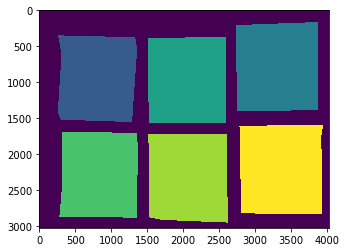

In [8]:
label_name_to_value = {
    "hc_tn": 1,
    "kd_zt_t1": 2,
    "kd_bs_t1": 3,
    "kd_yt_t1": 4,
    "kd_yt_t2": 5,
    "kd_yt_t3": 6,
    "kd_yt_t4": 7,
}
label = shapes_to_label(img_size, img_shapes, label_name_to_value)
plt.imshow(label)

'\nblurred = np.hstack([\ncv2.bilateralFilter(image, 5, 21, 21),\ncv2.bilateralFilter(image, 7, 31, 31),\ncv2.bilateralFilter(image, 9, 41, 41)])\ncv2.imshow("Bilateral", blurred)\ncv2.waitKey(0)\n'

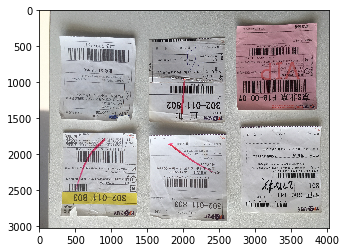

In [9]:
plt.imshow(img_data)
"""
blurred = np.hstack([
cv2.bilateralFilter(image, 5, 21, 21),
cv2.bilateralFilter(image, 7, 31, 31),
cv2.bilateralFilter(image, 9, 41, 41)])
cv2.imshow("Bilateral", blurred)
cv2.waitKey(0)
"""

## 练习 `cv2.resize`

(384, 512, 3)


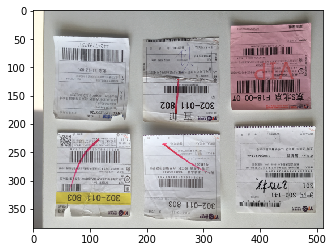

In [10]:
if True:
    img_small = imutils.resize(img_data, width=512)
else:
    h, w = img_data.shape[:2]
    r = 512.0 / w
    img_small = cv2.resize(img_data, (512, int(h*r)), interpolation=None) #cv2.INTER_AREA)
print(img_small.shape)
plt.imshow(img_small)

## 练习 画框、线、边界

In [18]:
canvases = []
for idx, shape in enumerate(img_shapes[:4]):
    transformers = []
    points = np.array(shape["points"], dtype=np.int32)
    print(points.shape)

    #canvas = img_data.copy()
    #cv2.polylines(canvas, [points.astype(np.int32)], isClosed=True, color=(255, 255, 255), thickness=10)

    # show出画布
    #plt.imshow(canvas); break

    
    # ###################################
    # 算bbox
    #
    #rect = cv2.boundingRect(points)
    
    #pt_upleft, pt_downright = convert_bounding_rect_to_bbox(rect)
    #print(["rect = ", rect, pt_upleft, pt_downright])

    #canvas = img_data.copy()
    #cv2.rectangle(canvas, pt_upleft, pt_downright, color=(255, 255, 255), thickness=20)
    
    # show出画布
    #plt.imshow(canvas); break
    
    
    # ###################################
    # STEP_1: 算旋转矫正时用到的偏转角(依赖之前算出的minAreaRect)
    # 算minAreaRect（实际上就是直接用了之前的结果）
    # NOTE: minAreaRect是本计算的副产品
    #
    angle, rotated_rect, pts = calc_polyrect_angle(points)
    center, size, angle_ = rotated_rect
    print(["pts=", pts])    
    print(["center=", center])
    print(["size=", size])
    print(["angle=", angle, angle_])
    
    #canvas = img_data.copy()
    #cv2.polylines(canvas, [pts.astype(np.int32)], isClosed=True, color=(255, 255, 255), thickness=10)
    
    # show出画布
    #plt.imshow(canvas); break
    
    
    # ###################################
    # STEP_2: 切出(crop)
    #
    pts = pts  # 输入，坐标变换完直接输出
    center = center  # 输入，坐标转换完直接输出
    
    cropped, points_cropped, _, m_translate = crop_img_by_polygon(
        img_data, points,
        pt_upleft="center",
        dsize="safe",
    )

    _, (pts_cropped, [center_cropped]) = warp_affine_transform(m_translate, points=[pts, [center]])
    transformers.append(m_translate)
    
    #canvas = cropped.copy()
    #cv2.polylines(canvas, [points_cropped.astype(np.int32)], isClosed=True, color=(255, 255, 255), thickness=10)
    
    # show出画布
    #plt.imshow(canvas); break


    # ###################################
    # STEP_3: 拉伸(stretch, 透视变换，依赖之前算出的minAreaRect)
    #
    # TODO: 这个选点的办法在偏转太大的情况下是会出错的，
    #       期望的结果是离目标rotated_rect的四个顶点最合理的四个锚点，
    #       当前只是简单计算离4个目标顶点距离最近的4个点。
    masked = cropped  # 输入
    points = points_cropped  # 输入
    pts = pts_cropped  # 输入
    
    # 从多边形外围边界挑选4个顶点与目标stretch的rectangle顶点形成透视变换源点组
    deltas = np.stack(map(
        f_compose_r(
            partial(np.subtract, pts),
            np.square,
            partial(np.sum, axis=1),
        ),
        points,
    ))
    corner_idxes = np.argmin(deltas, axis=0).tolist()
    pts_src = np.array(itemgetter(*corner_idxes)(points))
    pts_dst = pts
    print(["deltas=", deltas.shape, deltas])
    print(["corner_idxes=", corner_idxes])
    print(["pts_src=", pts_src])
    print(["pts_dst=", pts_dst])

    # 计算透视变换矩阵
    m_stretch = cv2.getPerspectiveTransform(pts_src.astype(np.float32), pts_dst.astype(np.float32))
    print(["m_stretch=", m_stretch])
    transformers.append(m_stretch)
    
    # 拉伸
    stretched, (points_stretched,) = warp_perspective_transform(
        m_stretch,
        mat=masked,
        points=[points],
    )
    #print(["points_stretched=", points_stretched.shape, points_stretched])
    
    # 下面连个边框先在画布上画上去，下面还要旋转。
    #canvas = stretched.copy()
    #cv2.polylines(canvas, [pts_src.astype(np.int32)], isClosed=True, color=(100, 255, 100), thickness=10)
    #cv2.polylines(canvas, [pts_dst.astype(np.int32)], isClosed=True, color=(200, 200, 200), thickness=10)

    # show出画布
    #plt.imshow(canvas); break

    
    # ###################################
    # STEP_4: 旋正(依赖之前算出的偏转角)
    #
    masked = stretched  # 输入
    points = points_stretched  # 输入
    center = tuple(center_cropped)  # 输入
    angle = angle  # 输入
    
    # 旋转
    rotated, (points_rotated,), *_, m_rotate = rotate_img(
        center,
        angle,
        1.0,
        mat=masked,
        points=[points],
    )
    #print(["points_rotated=", points_rotated.shape, points_rotated])
    transformers.append(m_rotate)
    
    # 画旋转过的边框
    # 这个会验证经过两次变换的边框，还是准确的。
    #canvas = rotated.copy()
    #cv2.polylines(canvas, [points_rotated.astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=10)

    # show出画布
    #plt.imshow(canvas); break
    
    
    # ###################################
    # STEP_5: 导出结果到loop外
    #
    masked = rotated
    points = points_rotated
    
    canvases.append(masked)

    shape_copy = shape.copy()
    shape_copy["points"] = points
    dump_shape("/tmp/shape_{}.json".format(idx), masked, shape_copy, transformers, info_template)


(8, 2)
['pts=', array([[ 233.4975 , 1528.3752 ],
       [1340.3274 , 1555.1699 ],
       [1368.8298 ,  377.79462],
       [ 261.99994,  350.99994]], dtype=float32)]
['center=', (801.1636352539062, 953.0848999023438)]
['size=', (1177.72021484375, 1107.1541748046875)]
['angle=', -178.61322784423828, -88.61322784423828]
['deltas=', (8, 4), array([[1.12108400e+06, 2.33690552e+03, 1.38936188e+06, 2.50810900e+06],
       [4.88499170e+03, 1.07721575e+06, 2.44291150e+06, 1.37058100e+06],
       [1.27753369e+04, 1.18133225e+06, 2.30918075e+06, 1.14062400e+06],
       [5.90629875e+05, 1.70358125e+06, 1.28437650e+06, 1.71425047e+05],
       [1.02906419e+06, 2.16632050e+06, 1.16577725e+06, 2.85210234e+04],
       [1.38702488e+06, 2.61281525e+06, 1.22579025e+06, 7.45058060e-09],
       [2.54117650e+06, 1.38810312e+06, 1.07842944e+03, 1.15415200e+06],
       [2.26510650e+06, 1.03931606e+06, 2.50436113e+04, 1.25083400e+06]],
      dtype=float32)]
['corner_idxes=', [1, 0, 6, 5]]
['pts_src=', array([[ 

TypeError: points is not a numpy array, neither a scalar

In [23]:
if False and len(canvases) > 0:
    canvas, *_ = crop_img_by_polygon(canvases[0], np.array([[0,0], [1800, 0], [1800, 1800], [0, 1800]]))
    #canvas = np.concatenate(f_compose_r(
    #    partial(map, f_compose_r(
    #        lambda _: crop_img_by_polygon(_, [[0,0], [1800, 0], [1800, 1800], [0, 1800]]),
    #        itemgetter(0),
    #    )),
    #    list,
    #)(canvases), axis=1)
    print(["canvas=", canvas.shape, len(canvases)])
    plt.imshow(canvas)
    # 画的多边形线是连贯的，不信你开大图看吧。
    cv2.imwrite("/tmp/1.jpg", canvas)
    pass

In [24]:
shape_mat, _, shapes_, *_ = load_labeled_img(invoice1_path)
shape_ = shapes_[0]
shape6 = shapes_[-1]

[[   1.    0. -262.]
 [   0.    1. -351.]]


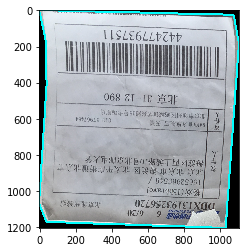

In [25]:
masked = shape_mat
points_ = np.array(shape_["points"], dtype=np.int32)
#cv2.polylines(masked, [np.array(points_).astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=10)
#plt.imshow(masked)

canvas = masked.copy()
masked, points_1, _, m = crop_img_by_polygon(
    masked, points_,
    #pt_upleft=(0,0),
    #pt_upleft="same",
    #pt_upleft="center",
    #dsize="same",
)
print(m)
cv2.polylines(masked, [np.array(points_1).astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=10)

plt.imshow(masked)

'\nmasked, (points_,), m = rotate_img(None, 45.0, 0.5, masked, [points_])\n#cv2.polylines(masked, [np.array(points_).astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=10)\n\nmasked, (points_,), m = translate_img([-200, 20], masked, [points_])\n#cv2.polylines(masked, [np.array(points_).astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=10)\n\nmasked, points_, _, m = crop_img_by_polygon(masked, points_, dsize="min")\ncv2.polylines(masked, [np.array(points_).astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=10)\n'

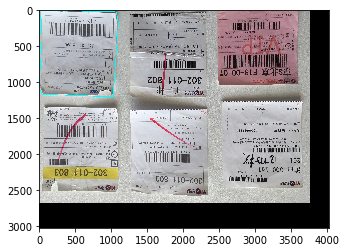

In [26]:
canvas, (points_2, *_) = warp_affine_transform(m, mat=canvas, points=[points_])
cv2.polylines(canvas, [np.array(points_2).astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=10)
plt.imshow(canvas)
"""
masked, (points_,), m = rotate_img(None, 45.0, 0.5, masked, [points_])
#cv2.polylines(masked, [np.array(points_).astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=10)

masked, (points_,), m = translate_img([-200, 20], masked, [points_])
#cv2.polylines(masked, [np.array(points_).astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=10)

masked, points_, _, m = crop_img_by_polygon(masked, points_, dsize="min")
cv2.polylines(masked, [np.array(points_).astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=10)
"""

#plt.imshow(masked)

True

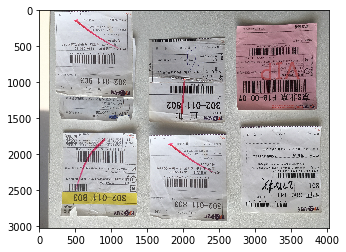

In [27]:
canvas = shape_mat.copy()

points6 = np.array(shape6["points"]).astype(np.int32)
points5 = np.array(shapes_[-2]["points"]).astype(np.int32)

masked, points6, *_ = crop_img_by_polygon(canvas, points6, pt_upleft="center", dsize="same")
masked, (points6,), *_ = rotate_img(None, 45, 1.2, masked, [points6])
#cv2.polylines(masked, [np.array(points6).astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=10)

masked, points6, m = paste_img(
    canvas, canvas, points5,
    pt_upleft=(200, 0),
)
#cv2.polylines(masked, [np.array(points6).astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=10)


"""
#mask = get_mask_from_polygons([points6], dsize=shape_mat.shape[:2][::-1])

mat6, points6, mask, _ = crop_img_by_polygon(canvas, points6, pt_upleft=(100, 100), dsize="same")

mask = np.bitwise_not(mask)
canvas = cv2.bitwise_and(canvas, canvas, mask=mask)
canvas = cv2.bitwise_or(canvas, mat6)
cv2.polylines(canvas, [np.array(points6).astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=10)
"""
canvas = masked
plt.imshow(canvas)
cv2.imwrite("/tmp/1.jpg", canvas)